# USING THE ENSEMBLE MODEL FOR A MOVIE
ADD SENTIMENTS AND ANALYSE

## INSTALL PRAW

In [ ]:
!pip install praw

## ENTER MOVIE NAME

In [34]:
# Prompt user to input a movie name
movie_name = input("Enter a movie name: ")

# Print the entered movie name
print(f"You entered: {movie_name}")

Enter a movie name: narnia
You entered: narnia


## GET THE COMMENTS FROM REDDIT AND CREATE DATASET

In [35]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning, module="praw")

import logging
# Suppress PRAW warnings
logging.getLogger("praw").setLevel(logging.CRITICAL)

import praw
import pandas as pd
import time
from datetime import datetime

# Reddit API credentials
reddit = praw.Reddit(
    client_id='E2jh-fCEPm1SQC01GQcVOQ',
    client_secret='65oz9bU3v2ns6V_7j-fJ7gS8dA077g',
    user_agent='MovieScraper/1.0'
)

# 1) Find all subreddits with "interstellar" in their name
movie_title = movie_name
found_subs = []
for sub in reddit.subreddits.search(movie_title, limit=50):
    # Check if subscriber count is not None before appending
    if movie_title.lower() in sub.display_name.lower() and sub.subscribers is not None:
        found_subs.append((sub.display_name, sub.subscribers))

# Sort subreddits by subscriber count (descending)
found_subs = sorted(found_subs, key=lambda x: x[1], reverse=True)

# Take top 5 subreddits
top_subs = found_subs[:5]

# 5) Display results
if top_subs:
    print(f"\nTop {len(top_subs)} subreddits related to '{movie_title}':\n")
    for i, (sub_name, subs) in enumerate(top_subs, 1):
        print(f"{i}. r/{sub_name} — {subs:,} subscribers")
else:
    print(f"\nNo subreddits found related to '{movie_title}'.")

# 2) Scrape settings
posts_per_type = 20000    # limit per category ('hot','new','top')
post_types = ['hot', 'new', 'top']

all_rows = []
sno = 1

# 3) Iterate, scrape, and continue on error
# The original code iterated over `found_subs` which contains tuples.
# We need to iterate over the subreddit names from the top_subs list instead.
for subreddit_tuple in top_subs: # Iterate over the top 5 subreddit tuples
    subreddit_name = subreddit_tuple[0] # Get the subreddit name from the tuple
    count = 0
    print(f"\n--- Scraping r/{subreddit_name} ---")
    try:
        subreddit = reddit.subreddit(subreddit_name)
        for pt in post_types:
            if pt == 'hot':
                posts = subreddit.hot(limit=posts_per_type)
            elif pt == 'new':
                posts = subreddit.new(limit=posts_per_type)
            else:
                posts = subreddit.top(limit=posts_per_type)

            for post in posts:
                # Add a check for post.selftext being None
                text = f"{post.title}\n\n{post.selftext if post.selftext is not None else ''}"
                date_str = datetime.utcfromtimestamp(post.created_utc).strftime('%Y-%m-%d %H:%M:%S')
                all_rows.append({
                    'SNO': sno,
                    'SUBREDDIT_NAME': subreddit_name,
                    'TEXT': text,
                    'DATE': date_str
                })
                sno += 1
                count += 1

            # be kind to Reddit’s API
            time.sleep(2)

        print(f"Completed r/{subreddit_name} — obtained {count} posts.")

    except Exception as e:
        print(f"Error scraping r/{subreddit_name}: {e}")
        # move on to next subreddit
        continue

# 4) Save to CSV
df = pd.DataFrame(all_rows, columns=['SNO', 'SUBREDDIT_NAME', 'TEXT', 'DATE'])
output_file = 'movie_comments.csv'
df.to_csv(output_file, index=False)

print(f"\nDone! Total posts collected: {len(df)}. Saved to '{output_file}'.")
print(df.head(10))


Top 5 subreddits related to 'narnia':

1. r/Narnia — 16,360 subscribers
2. r/NarniaMemes — 8,445 subscribers
3. r/ImaginaryNarnia — 773 subscribers
4. r/narnia_netflix — 631 subscribers
5. r/stuckinnarnia — 256 subscribers

--- Scraping r/Narnia ---
Completed r/Narnia — obtained 2974 posts.

--- Scraping r/NarniaMemes ---


KeyboardInterrupt: 

## GETTING SENTIMENTS USING ENSEMBLE MODEL

UPLOAD THE MODELS IN THE GOOGLE COLAB FOR SVM, NAIVE BAYES, XGBOOST, LSTM, TRANSFOMER

MODELS : (DOWNLOAD ZIP AND UNZIP IN DESKTOP) <br>
https://drive.google.com/drive/u/0/folders/13ayZaVAEfXEZQtNKEFJT_EA7fPgp7Bru

In [ ]:
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import pad_sequences
# Load Transformer model (with custom layers)
from tensorflow.keras.layers import Layer, MultiHeadAttention, Dense, Embedding, LayerNormalization
from tensorflow.keras.models import Sequential

# Load saved models and vectorizers
with open('svm_model.pkl', 'rb') as file:
    svm_model = pickle.load(file)

with open('svm_tfidf_vectorizer.pkl', 'rb') as file:
    svm_vectorizer = pickle.load(file)

with open('xgb_model.pkl', 'rb') as file:
    xgb_model = pickle.load(file)

with open('xgb_tfidf_vectorizer.pkl', 'rb') as file:
    tfidf_vectorizer = pickle.load(file)

with open('lstm_label_encoder.pkl', 'rb') as file:
    lstm_label_encoder = pickle.load(file)

lstm_model = load_model('lstm_model.h5')

with open('lstm_tokenizer.pkl', 'rb') as file:
    lstm_tokenizer = pickle.load(file)

with open('naive_bayes_model.pkl', 'rb') as file:
    nb_model = pickle.load(file)

with open('nb_tfidf_vectorizer.pkl', 'rb') as file:
    nb_vectorizer = pickle.load(file)

with open('transformer_label_encoder.pkl', 'rb') as file:
    t_label_encoder = pickle.load(file)

with open('transformer_vectorizer.pkl', 'rb') as file:
    t_vectorize_layer = pickle.load(file)

with open('meta_learner_rf.pkl', 'rb') as file:
    meta_learner_rf = pickle.load(file)

class EmbeddingLayer(Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(EmbeddingLayer, self).__init__(**kwargs)
        self.word_embedding = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.position_embedding = Embedding(input_dim=sequence_length, output_dim=embed_dim)

    def call(self, tokens):
        positions = tf.range(start=0, limit=tf.shape(tokens)[-1], delta=1)
        return self.word_embedding(tokens) + self.position_embedding(positions)

class EncoderLayer(Layer):
    def __init__(self, total_heads, total_dense_units, embed_dim, **kwargs):
        super(EncoderLayer, self).__init__(**kwargs)
        self.multihead = MultiHeadAttention(num_heads=total_heads, key_dim=embed_dim)
        self.nnw = Sequential([
            Dense(total_dense_units, activation="relu"),
            Dense(embed_dim)
        ])
        self.norm = LayerNormalization()

    def call(self, inputs):
        attn_output = self.multihead(inputs, inputs)
        x = self.norm(inputs + attn_output)
        nnw_output = self.nnw(x)
        return self.norm(x + nnw_output)

custom_objects = {
    "EmbeddingLayer": EmbeddingLayer,
    "EncoderLayer": EncoderLayer
}

transformer_model = load_model('transformer_model.h5', custom_objects=custom_objects)

# Load your unseen dataset
unseen_data = pd.read_csv('movie_comments.csv')
unseen_data.dropna(subset=['TEXT'], inplace=True)

# Preprocess unseen data
X_unseen = unseen_data['TEXT']

X_unseen_svm = svm_vectorizer.transform(X_unseen)
X_unseen_nb = nb_vectorizer.transform(X_unseen)
X_unseen_xgb = tfidf_vectorizer.transform(X_unseen)

X_unseen_lstm = lstm_tokenizer.texts_to_sequences(X_unseen)
X_unseen_lstm = pad_sequences(X_unseen_lstm, maxlen=100, padding='post', truncating='post')

# If your LSTM model uses sentiment as an input, dummy placeholder
X_unseen_sent = np.zeros((X_unseen.shape[0], 1))  # Adjust if you have sentiment input

X_unseen_transformer = t_vectorize_layer(X_unseen)

# Get model probabilities
svm_pred_proba = np.zeros((X_unseen.shape[0], len(t_label_encoder.classes_)))
svm_preds = svm_model.predict(X_unseen_svm)
svm_pred_proba[np.arange(X_unseen.shape[0]), svm_preds] = 1

nb_pred_proba = nb_model.predict_proba(X_unseen_nb)
xgb_pred_proba = xgb_model.predict_proba(X_unseen_xgb)

lstm_pred_proba = lstm_model.predict({'text_input': X_unseen_lstm, 'sentiment_input': X_unseen_sent})
transformer_pred_proba = transformer_model.predict(X_unseen_transformer)

# Stack features for meta-learner
stacked_unseen_features = np.hstack((
    svm_pred_proba,
    nb_pred_proba,
    xgb_pred_proba,
    lstm_pred_proba,
    transformer_pred_proba
))

# Predict with meta-learner
final_unseen_preds = meta_learner_rf.predict(stacked_unseen_features)
predicted_labels = t_label_encoder.inverse_transform(final_unseen_preds)

# Add predictions to the dataframe
unseen_data['predicted_sentiment'] = predicted_labels

# Save to new CSV
output_file = 'unseen_dataset_predictions.csv'
unseen_data.to_csv(output_file, index=False)

print(f"Predictions saved to: {output_file}")


377/377 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step
377/377 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Predictions saved to: unseen_dataset_predictions.csv


## ANALYSING THE RESULT

Unique predicted sentiments: [ 0  1 -1]

Sentiment counts:
predicted_sentiment
-1       77
 0    10635
 1     1338
Name: count, dtype: int64


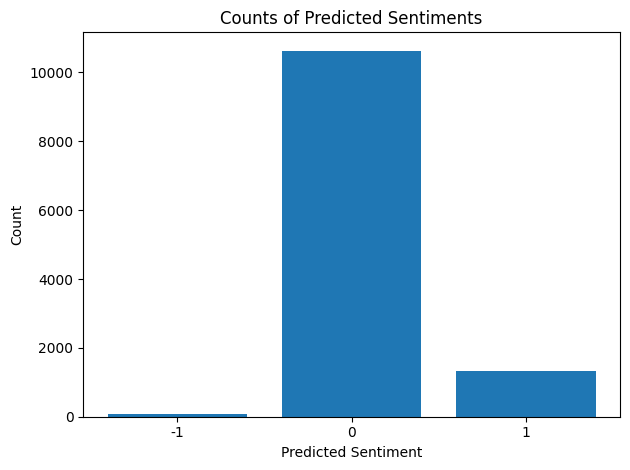

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('unseen_dataset_predictions.csv')

# 1. Unique values in 'predicted_sentiment'
unique_vals = df['predicted_sentiment'].unique()
print("Unique predicted sentiments:", unique_vals)

# 2. Counts for sentiments -1, 0, 1
counts = df['predicted_sentiment'].value_counts().reindex([-1, 0, 1], fill_value=0)
print("\nSentiment counts:")
print(counts)

neg = counts.loc[-1]
neu = counts.loc[0]
pos = counts.loc[1]

# 3. Visualize counts in a bar chart
plt.figure()
plt.bar(counts.index.astype(str), counts.values)
plt.xlabel('Predicted Sentiment')
plt.ylabel('Count')
plt.title('Counts of Predicted Sentiments')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## GIVE A STATEMENT

In [ ]:
def humanize_summary(total, pct_pos, pct_neu, pct_neg):
    # round numbers neatly
    pos = round(pct_pos, 1)
    neu = round(pct_neu, 1)
    neg = round(pct_neg, 1)

    # pick a lead-in
    lead = f"We analyzed {total:,} {movie_name} comments"

    # build fragments
    parts = [
        f"{pos}% were positive",
        f"{neu}% were neutral",
        f"{neg}% were negative",
    ]

    # join with commas, last with "and"
    body = ", ".join(parts[:-1]) + ", and " + parts[-1]

    return f"{lead} — {body}."

# 1) Compute total and percentages
total = neg + neu + pos
pct_neg = neg  / total * 100
pct_neu = neu  / total * 100
pct_pos = pos  / total * 100

# 2) Generate the humanized summary
summary = humanize_summary(
    total=total,
    pct_pos=pct_pos,
    pct_neu=pct_neu,
    pct_neg=pct_neg
)

print(summary)


We analyzed 12,050 avengers comments — 11.1% were positive, 88.3% were neutral, and 0.6% were negative.
